<a href="https://colab.research.google.com/github/XNN19/CCN2024/blob/main/RSA/Part1_Tuning_vs_Geometry_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quantifying Similarity between Neural Population Codes**

*Computational Cognitive Neuroscience*

*Keynotes and Tutorials*

*August 7, 2024*

# **Part 1: Neural Tuning, Geometry, and Procrustes shape distance**


**Prerequisites**

To follow along with the code, you will need to be familiar with several standard Python packages for scientific applications: `numpy`, `scipy`, `sklearn`, and `matplotlib`. You will also need to be familiar with some standard linear algebra routines, like [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA) and [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD).

**Background Reading**

* Kriegeskorte, N., Wei, XX. (2021). [Neural tuning and representational geometry](https://doi.org/10.1038/s41583-021-00502-3). *Nat Rev Neurosci* 22, 703-718.

* Williams, A. H., Kunz, E., Kornblith, S., & Linderman, S. (2021). [Generalized shape metrics on neural representations](https://proceedings.neurips.cc/paper/2021/hash/252a3dbaeb32e7690242ad3b556e626b-Abstract.html). *Advances in Neural Information Processing Systems*, 34, 4738-4750.

In this tutorial, we are going to analyze a simple neural representation of a 1-dimensional, periodic sensory variable. For example, a standard protocol to characterize neural responses in early visual cortex is to show a series of oriented grating stimuli like the examples below:

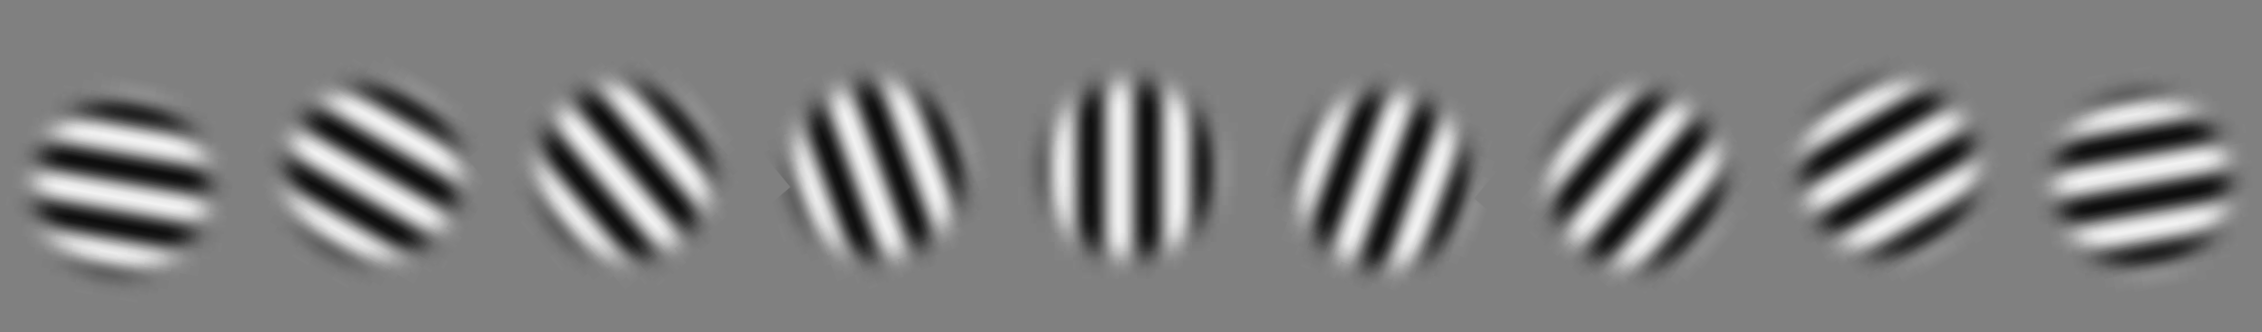

Many neurons in primary visual cortex (V1) are "tuned" (i.e. respond preferentially to) to particular grating orientations. An idealized population of V1 neurons can be summarized by a series of "tuning curves" which show the mean firing rate response as a function of the angle of orientation, which we denote as $\theta$.

The review by [Kriegeskorte & Wei (2021)](https://doi.org/10.1038/s41583-021-00502-3) provides a thorough overview of how different tuning curve statistics relate to population-level geometry. Below we show an excerpt from Figure 4.

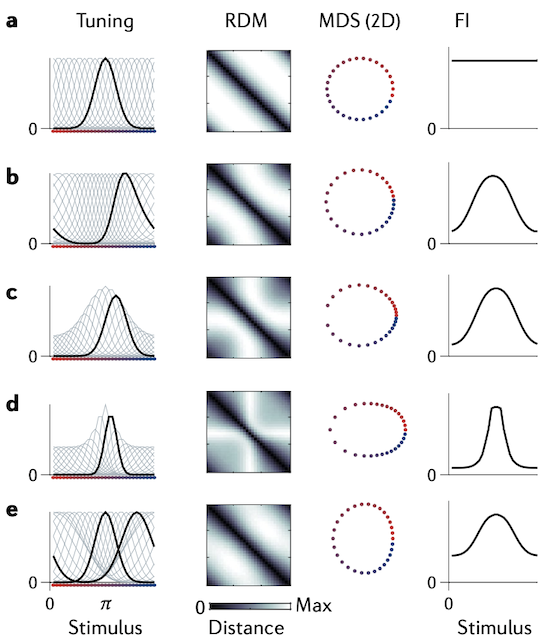

## **Getting Started**

We will use mostly standard Python packages for the purposes of this tutorial. The code block immediately below imports them.

Additionally, we create a custom circular colormap for `matplotlib` to visualize periodic tuning curves parameterized by $\theta$.

In [ ]:
#@title Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
#@title Create custom colormap for plotting.
import matplotlib
cyclic_cmap = matplotlib.colors.ListedColormap(
    np.array([[0.91510904, 0.55114749, 0.67037311],
   [0.91696411, 0.55081563, 0.66264366],
   [0.91870995, 0.55055664, 0.65485881],
   [0.92034498, 0.55037149, 0.64702356],
   [0.92186763, 0.55026107, 0.63914306],
   [0.92327636, 0.55022625, 0.63122259],
   [0.9245696 , 0.55026781, 0.62326754],
   [0.92574582, 0.5503865 , 0.6152834 ],
   [0.92680349, 0.55058299, 0.6072758 ],
   [0.92774112, 0.55085789, 0.59925045],
   [0.9285572 , 0.55121174, 0.59121319],
   [0.92925027, 0.551645  , 0.58316992],
   [0.92981889, 0.55215808, 0.57512667],
   [0.93026165, 0.55275127, 0.56708953],
   [0.93057716, 0.5534248 , 0.55906469],
   [0.93076407, 0.55417883, 0.55105838],
   [0.93082107, 0.55501339, 0.54307696],
   [0.93074689, 0.55592845, 0.53512681],
   [0.9305403 , 0.55692387, 0.52721438],
   [0.93020012, 0.55799943, 0.51934621],
   [0.92972523, 0.55915477, 0.51152885],
   [0.92911454, 0.56038948, 0.50376893],
   [0.92836703, 0.56170301, 0.49607312],
   [0.92748175, 0.56309471, 0.48844813],
   [0.9264578 , 0.56456383, 0.48090073],
   [0.92529434, 0.56610951, 0.47343769],
   [0.92399062, 0.56773078, 0.46606586],
   [0.92254595, 0.56942656, 0.45879209],
   [0.92095971, 0.57119566, 0.4516233 ],
   [0.91923137, 0.5730368 , 0.44456642],
   [0.91736048, 0.57494856, 0.4376284 ],
   [0.91534665, 0.57692945, 0.43081625],
   [0.91318962, 0.57897785, 0.42413698],
   [0.91088917, 0.58109205, 0.41759765],
   [0.90844521, 0.58327024, 0.41120533],
   [0.90585771, 0.58551053, 0.40496711],
   [0.90312676, 0.5878109 , 0.3988901 ],
   [0.90025252, 0.59016928, 0.39298143],
   [0.89723527, 0.5925835 , 0.38724821],
   [0.89407538, 0.59505131, 0.38169756],
   [0.89077331, 0.59757038, 0.37633658],
   [0.88732963, 0.60013832, 0.37117234],
   [0.88374501, 0.60275266, 0.36621186],
   [0.88002022, 0.6054109 , 0.36146209],
   [0.87615612, 0.60811044, 0.35692989],
   [0.87215369, 0.61084868, 0.352622  ],
   [0.86801401, 0.61362295, 0.34854502],
   [0.86373824, 0.61643054, 0.34470535],
   [0.85932766, 0.61926872, 0.3411092 ],
   [0.85478365, 0.62213474, 0.3377625 ],
   [0.85010767, 0.6250258 , 0.33467091],
   [0.84530131, 0.62793914, 0.3318397 ],
   [0.84036623, 0.63087193, 0.32927381],
   [0.8353042 , 0.63382139, 0.32697771],
   [0.83011708, 0.63678472, 0.32495541],
   [0.82480682, 0.63975913, 0.32321038],
   [0.81937548, 0.64274185, 0.32174556],
   [0.81382519, 0.64573011, 0.32056327],
   [0.80815818, 0.6487212 , 0.31966522],
   [0.80237677, 0.65171241, 0.31905244],
   [0.79648336, 0.65470106, 0.31872531],
   [0.79048044, 0.65768455, 0.31868352],
   [0.78437059, 0.66066026, 0.31892606],
   [0.77815645, 0.66362567, 0.31945124],
   [0.77184076, 0.66657827, 0.32025669],
   [0.76542634, 0.66951562, 0.3213394 ],
   [0.75891609, 0.67243534, 0.32269572],
   [0.75231298, 0.67533509, 0.32432138],
   [0.74562004, 0.6782126 , 0.32621159],
   [0.73884042, 0.68106567, 0.32836102],
   [0.73197731, 0.68389214, 0.33076388],
   [0.72503398, 0.68668995, 0.33341395],
   [0.7180138 , 0.68945708, 0.33630465],
   [0.71092018, 0.69219158, 0.33942908],
   [0.70375663, 0.69489159, 0.34278007],
   [0.69652673, 0.69755529, 0.34635023],
   [0.68923414, 0.70018097, 0.35013201],
   [0.6818826 , 0.70276695, 0.35411772],
   [0.67447591, 0.70531165, 0.3582996 ],
   [0.667018  , 0.70781354, 0.36266984],
   [0.65951284, 0.71027119, 0.36722061],
   [0.65196451, 0.71268322, 0.37194411],
   [0.64437719, 0.71504832, 0.37683259],
   [0.63675512, 0.71736525, 0.38187838],
   [0.62910269, 0.71963286, 0.38707389],
   [0.62142435, 0.72185004, 0.39241165],
   [0.61372469, 0.72401576, 0.39788432],
   [0.60600841, 0.72612907, 0.40348469],
   [0.59828032, 0.72818906, 0.40920573],
   [0.59054536, 0.73019489, 0.41504052],
   [0.58280863, 0.73214581, 0.42098233],
   [0.57507535, 0.7340411 , 0.42702461],
   [0.5673509 , 0.7358801 , 0.43316094],
   [0.55964082, 0.73766224, 0.43938511],
   [0.55195081, 0.73938697, 0.44569104],
   [0.54428677, 0.74105381, 0.45207286],
   [0.53665478, 0.74266235, 0.45852483],
   [0.52906111, 0.74421221, 0.4650414 ],
   [0.52151225, 0.74570306, 0.47161718],
   [0.5140149 , 0.74713464, 0.47824691],
   [0.506576  , 0.74850672, 0.48492552],
   [0.49920271, 0.74981912, 0.49164808],
   [0.49190247, 0.75107171, 0.4984098 ],
   [0.48468293, 0.75226438, 0.50520604],
   [0.47755205, 0.7533971 , 0.51203229],
   [0.47051802, 0.75446984, 0.5188842 ],
   [0.46358932, 0.75548263, 0.52575752],
   [0.45677469, 0.75643553, 0.53264815],
   [0.45008317, 0.75732863, 0.5395521 ],
   [0.44352403, 0.75816207, 0.54646551],
   [0.43710682, 0.758936  , 0.55338462],
   [0.43084133, 0.7596506 , 0.56030581],
   [0.42473758, 0.76030611, 0.56722555],
   [0.41880579, 0.76090275, 0.5741404 ],
   [0.41305637, 0.76144081, 0.58104704],
   [0.40749984, 0.76192057, 0.58794226],
   [0.40214685, 0.76234235, 0.59482292],
   [0.39700806, 0.7627065 , 0.60168598],
   [0.39209414, 0.76301337, 0.6085285 ],
   [0.38741566, 0.76326334, 0.6153476 ],
   [0.38298304, 0.76345681, 0.62214052],
   [0.37880647, 0.7635942 , 0.62890454],
   [0.37489579, 0.76367593, 0.63563704],
   [0.37126045, 0.76370246, 0.64233547],
   [0.36790936, 0.76367425, 0.64899736],
   [0.36485083, 0.76359176, 0.6556203 ],
   [0.36209245, 0.76345549, 0.66220193],
   [0.359641  , 0.76326594, 0.66873999],
   [0.35750235, 0.76302361, 0.67523226],
   [0.35568141, 0.76272903, 0.68167659],
   [0.35418202, 0.76238272, 0.68807086],
   [0.3530069 , 0.76198523, 0.69441305],
   [0.35215761, 0.7615371 , 0.70070115],
   [0.35163454, 0.76103888, 0.70693324],
   [0.35143685, 0.76049114, 0.71310742],
   [0.35156253, 0.75989444, 0.71922184],
   [0.35200839, 0.75924936, 0.72527472],
   [0.3527701 , 0.75855647, 0.73126429],
   [0.3538423 , 0.75781637, 0.73718884],
   [0.3552186 , 0.75702964, 0.7430467 ],
   [0.35689171, 0.75619688, 0.74883624],
   [0.35885353, 0.75531868, 0.75455584],
   [0.36109522, 0.75439565, 0.76020396],
   [0.36360734, 0.75342839, 0.76577905],
   [0.36637995, 0.75241752, 0.77127961],
   [0.3694027 , 0.75136364, 0.77670417],
   [0.37266493, 0.75026738, 0.7820513 ],
   [0.37615579, 0.74912934, 0.78731957],
   [0.37986429, 0.74795017, 0.79250759],
   [0.38377944, 0.74673047, 0.797614  ],
   [0.38789026, 0.74547088, 0.80263746],
   [0.3921859 , 0.74417203, 0.80757663],
   [0.39665568, 0.74283455, 0.81243022],
   [0.40128912, 0.74145908, 0.81719695],
   [0.406076  , 0.74004626, 0.82187554],
   [0.41100641, 0.73859673, 0.82646476],
   [0.41607073, 0.73711114, 0.83096336],
   [0.4212597 , 0.73559013, 0.83537014],
   [0.42656439, 0.73403435, 0.83968388],
   [0.43197625, 0.73244447, 0.8439034 ],
   [0.43748708, 0.73082114, 0.84802751],
   [0.44308905, 0.72916502, 0.85205505],
   [0.44877471, 0.72747678, 0.85598486],
   [0.45453694, 0.72575709, 0.85981579],
   [0.46036897, 0.72400662, 0.8635467 ],
   [0.4662644 , 0.72222606, 0.86717646],
   [0.47221713, 0.72041608, 0.87070395],
   [0.47822138, 0.71857738, 0.87412804],
   [0.4842717 , 0.71671065, 0.87744763],
   [0.4903629 , 0.71481659, 0.88066162],
   [0.49649009, 0.71289591, 0.8837689 ],
   [0.50264864, 0.71094931, 0.88676838],
   [0.50883417, 0.70897752, 0.88965898],
   [0.51504253, 0.70698127, 0.89243961],
   [0.52126981, 0.70496128, 0.8951092 ],
   [0.52751231, 0.70291829, 0.89766666],
   [0.53376652, 0.70085306, 0.90011093],
   [0.54002912, 0.69876633, 0.90244095],
   [0.54629699, 0.69665888, 0.90465565],
   [0.55256715, 0.69453147, 0.90675397],
   [0.55883679, 0.69238489, 0.90873487],
   [0.56510323, 0.69021993, 0.9105973 ],
   [0.57136396, 0.68803739, 0.91234022],
   [0.57761655, 0.68583808, 0.91396258],
   [0.58385872, 0.68362282, 0.91546336],
   [0.59008831, 0.68139246, 0.91684154],
   [0.59630323, 0.67914782, 0.9180961 ],
   [0.60250152, 0.67688977, 0.91922603],
   [0.60868128, 0.67461918, 0.92023033],
   [0.61484071, 0.67233692, 0.921108  ],
   [0.62097809, 0.67004388, 0.92185807],
   [0.62709176, 0.66774097, 0.92247957],
   [0.63318012, 0.66542911, 0.92297153],
   [0.63924166, 0.66310923, 0.92333301],
   [0.64527488, 0.66078227, 0.92356308],
   [0.65127837, 0.65844919, 0.92366082],
   [0.65725076, 0.65611096, 0.92362532],
   [0.66319071, 0.65376857, 0.92345572],
   [0.66909691, 0.65142302, 0.92315115],
   [0.67496813, 0.64907533, 0.92271076],
   [0.68080311, 0.64672651, 0.92213374],
   [0.68660068, 0.64437763, 0.92141929],
   [0.69235965, 0.64202973, 0.92056665],
   [0.69807888, 0.6396839 , 0.91957507],
   [0.70375724, 0.63734122, 0.91844386],
   [0.70939361, 0.63500279, 0.91717232],
   [0.7149869 , 0.63266974, 0.91575983],
   [0.72053602, 0.63034321, 0.91420578],
   [0.72603991, 0.62802433, 0.9125096 ],
   [0.7314975 , 0.62571429, 0.91067077],
   [0.73690773, 0.62341425, 0.9086888 ],
   [0.74226956, 0.62112542, 0.90656328],
   [0.74758193, 0.61884899, 0.90429382],
   [0.75284381, 0.6165862 , 0.90188009],
   [0.75805413, 0.61433829, 0.89932181],
   [0.76321187, 0.6121065 , 0.89661877],
   [0.76831596, 0.6098921 , 0.89377082],
   [0.77336536, 0.60769637, 0.89077786],
   [0.77835901, 0.6055206 , 0.88763988],
   [0.78329583, 0.6033661 , 0.88435693],
   [0.78817477, 0.60123418, 0.88092913],
   [0.79299473, 0.59912616, 0.87735668],
   [0.79775462, 0.59704339, 0.87363986],
   [0.80245335, 0.59498722, 0.86977904],
   [0.8070898 , 0.592959  , 0.86577468],
   [0.81166284, 0.5909601 , 0.86162732],
   [0.81617134, 0.5889919 , 0.8573376 ],
   [0.82061414, 0.58705579, 0.85290625],
   [0.82499007, 0.58515315, 0.84833413],
   [0.82929796, 0.58328538, 0.84362217],
   [0.83353661, 0.58145389, 0.83877142],
   [0.8377048 , 0.57966009, 0.83378306],
   [0.8418013 , 0.57790538, 0.82865836],
   [0.84582486, 0.57619119, 0.82339871],
   [0.84977422, 0.57451892, 0.81800565],
   [0.85364809, 0.57289   , 0.8124808 ],
   [0.85744519, 0.57130585, 0.80682595],
   [0.86116418, 0.56976788, 0.80104298],
   [0.86480373, 0.56827749, 0.79513394],
   [0.86836249, 0.56683612, 0.789101  ],
   [0.87183909, 0.56544515, 0.78294645],
   [0.87523214, 0.56410599, 0.77667274],
   [0.87854024, 0.56282002, 0.77028247],
   [0.88176195, 0.56158863, 0.76377835],
   [0.88489584, 0.56041319, 0.75716326],
   [0.88794045, 0.55929505, 0.75044023],
   [0.89089432, 0.55823556, 0.74361241],
   [0.89375596, 0.55723605, 0.73668312],
   [0.89652387, 0.55629781, 0.72965583],
   [0.89919653, 0.55542215, 0.72253414],
   [0.90177242, 0.55461033, 0.71532181],
   [0.90425   , 0.55386358, 0.70802274],
   [0.90662774, 0.55318313, 0.70064098],
   [0.90890408, 0.55257016, 0.69318073],
   [0.91107745, 0.55202582, 0.68564633],
   [0.91314629, 0.55155124, 0.67804225]])
)

## **Creating and Visualizing Simulated Data**

The code below defines a Python class `PeriodicTuningCurves` which will help us simulate a population of neurons with 1D periodic tuning, similar to the ones shown in the figure above. The details here do not matter too much to the conceptual point of the tutorial.

In [ ]:
#@title `PeriodicTuningCurves` class to define representations
class PeriodicTuningCurves:

    def __init__(self, num_neurons, tuning_width, amplitude):
        self.centers = np.linspace(0, 2 * np.pi, num_neurons + 1)[:-1]
        self.num_neurons = num_neurons
        self.tuning_width = tuning_width
        self.amplitude = amplitude

    def __call__(self, theta):
        assert theta.ndim == 1
        scaling_factor = (self.amplitude / np.exp(1 / self.tuning_width))
        tuning = np.exp(
            -np.cos(self.centers[None, :] - theta[:, None]) / self.tuning_width
        )
        return scaling_factor * tuning

Now we use the class above to create two "neural representations" of the periodic 1D stimulus $\theta$. You can think of these two representations as recordings from two different animals or activations from the hidden layers of two different artificial neural networks.

We can roughly think of these representations as matrices $\mathbf{X} \in \mathbb{R}^{M \times N}$ and $\mathbf{Y} \in \mathbb{R}^{M \times N}$ where $M$ denotes the number of stimulus conditions (e.g. number of orientations shown) and $N$ denotes the number of neurons in each population. We will call $\mathbf{X}$ and $\mathbf{Y}$ *response matrices*.<sup>1</sup>

Importantly, the same $M$ stimulus inputs are delivered to the two networks so that the rows of $\mathbf{X}$ and $\mathbf{Y}$ are already "matched."
However, the $N$ columns of $\mathbf{X}$ and $\mathbf{Y}$ are generally not "matched" because the neurons we measure in two different neural systems are labelled arbitrarily. In fact, we often are interested in comparing neural populations of different sizes! **Figuring out how to appropriately "match" neurons across two systems is the very core of our problem.**

For now we assume that $\mathbf{X}$ and $\mathbf{Y}$ have the same number of neurons, $N$. This is a useful simplification to build intuition. We will show how to relax this assumption shortly.

---

<sup>1</sup> *It is a bit of an over-simplification to view neural representations as matrices. More formally, a neural representation is a function $f: \theta \mapsto \mathbb{R}^N$. The matrix representation is an approximation of this function, formed by discretizing the input space into $M$ stimulus conditions $\theta_1, \dots, \theta_M$. For large $M$, we can accurately describe the function by stacking the $N$-dimensional vectors $f(\theta_1), \dots f(\theta_M)$ into an $M \times N$ matrix. However, we should not forget that this is an approximation, and actually the approximation should be expected to fail for very complex, high-dimensional input spaces (see [Curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)). We will return to this point later.*

In [ ]:
#@title Define `X` and `Y` representation matrices

# Create two "neural networks" that map stimulus inputs to high-d outputs.
num_neurons = 100
rep_X = PeriodicTuningCurves(num_neurons, 0.5, 1.0)
rep_Y = PeriodicTuningCurves(num_neurons, 0.05, 1.0)

# A one-dimensional periodic stimulus
num_conditions = 1000
thetas = np.linspace(-np.pi, np.pi, num_conditions)

# Evaluate the "neural networks" to get representation matrices
X = rep_X(thetas)   # num_conditions x num_neurons matrix
Y = rep_Y(thetas)   # num_conditions x num_neurons matrix

The code above creates two response matrices: $\mathbf{X} \in \mathbb{R}^{M \times N}$ and $\mathbf{Y} \in \mathbb{R}^{M \times N}$. Where $M$ is `num_conditions` and $N$ is `num_neurons`.

Now let's visualize the population responses in three ways.

1. *Plotting Tuning Curves.* Here we plot a subset of rows in $\mathbf{X}$ and $\mathbf{Y}$. Because there are many neurons, we can't visualize the full population activity this way.

2. *Plotting Heatmaps.* Here we visualize the responses of all neurons sorted by their peak firing rate.

3. *Using PCA.* Here we independently apply Principal Component Analysis to $\mathbf{X}$ and $\mathbf{Y}$ and obtain a low-dimensional visualization of the neural responses. In this case, because the responses arise from a continuous change in the underlying input variable, $\theta$, the neural activity traces out a smooth, one-dimensional ring structure. We call this a *neural manifold* or a *neural response manifold* (see [Manifold](https://en.wikipedia.org/wiki/Manifold) page on wikipedia for more precise mathematical definitions).

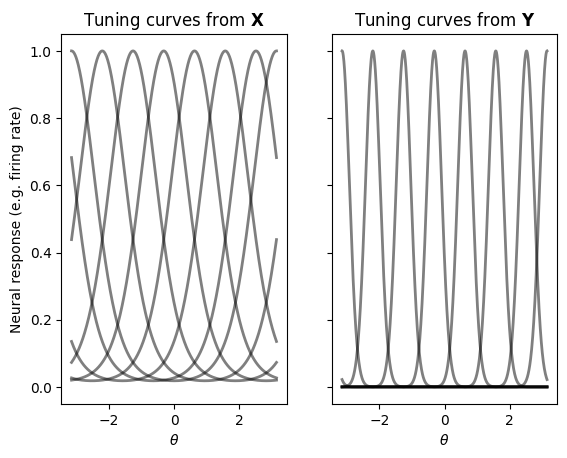

In [ ]:
#@title Plot a selection of Tuning Curves
fig, axes = plt.subplots(1, 2, sharey=True)
axes[0].plot(thetas, X[:, ::15], '-k', alpha=.5, lw=2)
axes[1].plot(thetas, Y[:, ::15], '-k', alpha=.5, lw=2)

axes[0].set_title(r"Tuning curves from $\mathbf{X}$")
axes[1].set_title(r"Tuning curves from $\mathbf{Y}$")

axes[0].set_xlabel(r"$\theta$")
axes[1].set_xlabel(r"$\theta$")
axes[0].set_ylabel("Neural response (e.g. firing rate)");

What is the difference between these two representations?  

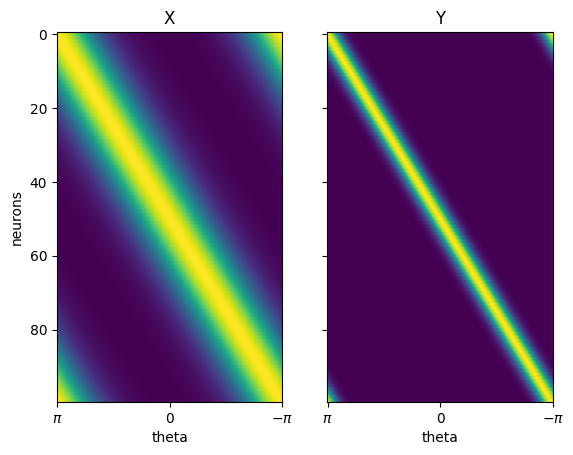

In [ ]:
#@title Plot Heatmap of Population activity
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
axes[0].imshow(X.T, aspect='auto')
axes[1].imshow(Y.T, aspect='auto')

axes[0].set_xlabel('theta')
axes[0].set_ylabel('neurons')
axes[0].set_title('X')
axes[1].set_title('Y')
axes[1].set_xlabel('theta')
axes[0].set_xticks([0, X.shape[0] / 2, X.shape[0]])
axes[0].set_xticklabels([r"$\pi$", 0, r"$-\pi$"]);

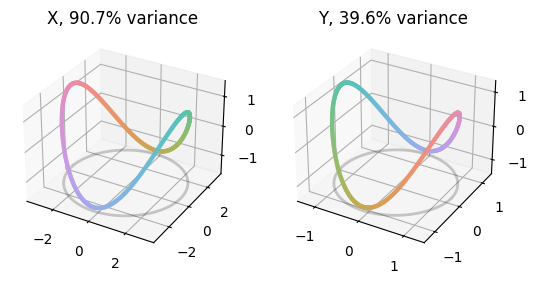

In [ ]:
#@title Plot Separate PCA Projections of `X` and `Y`.
pca_x = PCA(3).fit(X)
pca_y = PCA(3).fit(Y)

x1, x2, x3 = pca_x.transform(X).T
y1, y2, y3 = pca_y.transform(Y).T

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax1.scatter(x1, x2, x3, c=thetas, cmap=cyclic_cmap, alpha=.5, lw=0, s=10)
ax2.scatter(y1, y2, y3, c=thetas, cmap=cyclic_cmap, alpha=.5, lw=0, s=10)
ax1.plot(x1, x2, np.full_like(x1, ax1.get_zlim()[0]), '-k', alpha=.2, lw=2)
ax2.plot(y1, y2, np.full_like(y1, ax2.get_zlim()[0]), '-k', alpha=.2, lw=2)

ax1.set_title('X, {0:.1f}% variance'.format(
    100 * np.sum(pca_x.explained_variance_ratio_)
))
ax2.set_title('Y, {0:.1f}% variance'.format(
    100 * np.sum(pca_y.explained_variance_ratio_)
));

🛑 What do the colors correspond to on these plots?  

## **Tuning Determines Geometry, Geometry Does Not Determine Tuning**

In this tutorial we are mostly interested in comparing population response matrices, here $\mathbf{X}$ and $\mathbf{Y}$, in terms of their geometry rather than the tuning of individual neurons.<sup>1</sup> In the dataset we've simulated, we saw above that these population responses trace out a continous 1D ring *manifold* in $N$-dimensional firing rate space. These manifolds can be visualized by PCA, and their shapes look roughly similar.

Is this intuition correct, and how can we quantify it precisely? To take steps towards an answer, let's first discuss the difference between *geometry* and *tuning* a little more carefully.

Below we show that the geometry, or *shape*, of the neural manifold is invariant to rigid translations (i.e. adding an $N$-dimensional offset vector to each row in $\mathbf{X}$) and invariant to rotations and reflections (i.e. multiplying the response matrix by an $N \times N$ orthogonal matrix). However, translations and rotations impact what the tuning of individual neurons looks like.

------------------------
<sup>1</sup> *But see [Khosla et al. (2024)](https://www.biorxiv.org/content/10.1101/2024.06.20.599957v1.abstract) and [Khosla & Williams (2024)](https://proceedings.mlr.press/v243/khosla24a) for recent work on comparing neural population responses at the level of neural tuning.*

In [ ]:
#@title Apply random rotation of the neural firing rate space

def randrot(num_dims, seed):
    """Creates a random orthogonal matrix."""
    rs = np.random.RandomState(seed)
    return np.linalg.qr(rs.randn(num_dims, num_dims))[0]

# Create Xr, a randomly rotated copy of X
Rx = randrot(num_neurons, 0)
Xr = (X - np.mean(X, axis=0)) @ Rx

# Create Yr, a randomly rotated copy of Y
Ry = randrot(num_neurons, 1)
Yr = (Y - np.mean(Y, axis=0)) @ Ry

The code above creates two randomly rotated neural response matrices, `Xr` and `Yr`. Mathematically this is can be expressed as:

\begin{equation}
\mathbf{X} \mapsto \mathbf{C} \mathbf{X} \mathbf{R}_X \qquad \text{and} \qquad \mathbf{Y} \mapsto \mathbf{C} \mathbf{Y} \mathbf{R}_Y
\end{equation}

where $\mathbf{C}$ is a [centering matrix](https://en.wikipedia.org/wiki/Centering_matrix) and $\mathbf{R}_X$ and $\mathbf{R}_Y$ are randomly sampled $N$-dimensional [orthogonal matrices](https://en.wikipedia.org/wiki/Orthogonal_matrix).

Matrix multiplication on the left hand side by $\mathbf{C}$ results in centering the columns of $\mathbf{X}$ and $\mathbf{Y}$ so that their means are zero. Geometrically, this corresponds to centering the neural response manifold at the origin.
Matrix multiplication on the right hand side by $\mathbf{R}_X$ or $\mathbf{R}_Y$ corresponds to randomly rotating and potentially reflecting the manifold across some axis.

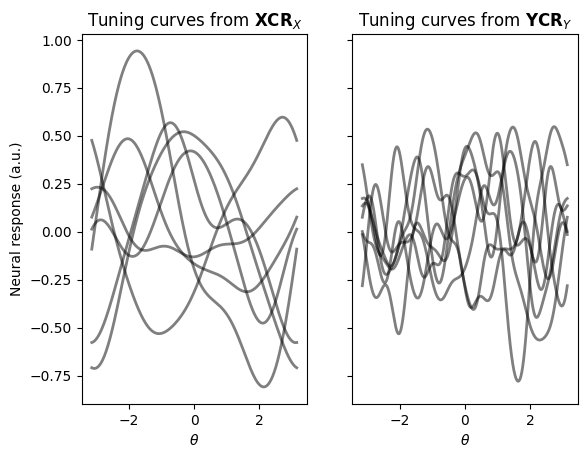

In [ ]:
#@title Plot Tuning Curves of `Xr` and `Yr`
fig, axes = plt.subplots(1, 2, sharey=True)
axes[0].plot(thetas, Xr[:, ::15], '-k', alpha=.5, lw=2)
axes[1].plot(thetas, Yr[:, ::15], '-k', alpha=.5, lw=2);

axes[0].set_title(r"Tuning curves from $\mathbf{X C R}_X$")
axes[1].set_title(r"Tuning curves from $\mathbf{Y C R}_Y$")

axes[0].set_xlabel(r"$\theta$")
axes[1].set_xlabel(r"$\theta$")
axes[0].set_ylabel("Neural response (a.u.)");

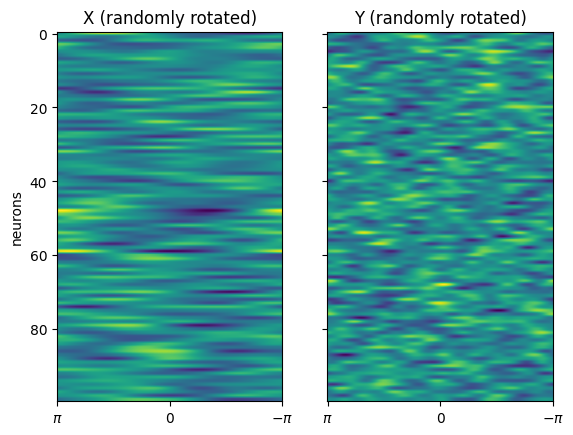

In [ ]:
#@title Plot heatmaps of `Xr` and `Yr`
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
axes[0].imshow(Xr.T, aspect='auto')
axes[1].imshow(Yr.T, aspect='auto')

axes[0].set_ylabel('neurons')
axes[0].set_title('X (randomly rotated)')
axes[1].set_title('Y (randomly rotated)')
axes[0].set_xticks([0, X.shape[0] / 2, X.shape[0]])
axes[0].set_xticklabels([r"$\pi$", 0, r"$-\pi$"]);

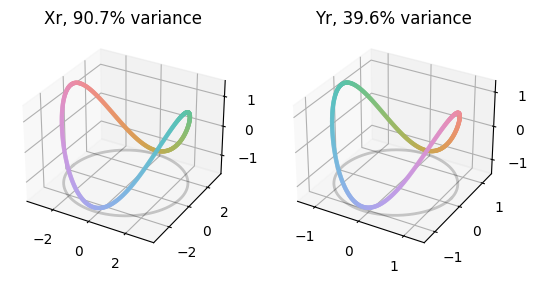

In [ ]:
#@title Plot Separate PCA Projections of `Xr` and `Yr`.
pca_x= PCA(3).fit(Xr)
pca_y= PCA(3).fit(Yr)

x1, x2, x3 = pca_x.transform(Xr).T
y1, y2, y3 = pca_y.transform(Yr).T

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax1.scatter(x1, x2, x3, c=thetas, cmap=cyclic_cmap, alpha=.5, lw=0, s=10)
ax2.scatter(y1, y2, y3, c=thetas, cmap=cyclic_cmap, alpha=.5, lw=0, s=10)
ax1.plot(x1, x2, np.full_like(x1, ax1.get_zlim()[0]), '-k', alpha=.2, lw=2)
ax2.plot(y1, y2, np.full_like(y1, ax2.get_zlim()[0]), '-k', alpha=.2, lw=2)

ax1.set_title('Xr, {0:.1f}% variance'.format(
    100 * np.sum(pca_x.explained_variance_ratio_)
))
ax2.set_title('Yr, {0:.1f}% variance'.format(
    100 * np.sum(pca_y.explained_variance_ratio_)
));

❗**Notice**❗ *The PCA projections of `Xr` and `Yr` look identical to what we saw before for `X` and `Y` and they explain the same amount of variance in the data. Even though the tuning curves of `Xr` and `Yr` are strikingly different than `X` and `Y` (see above), they will look the same in their PCA projections. That is, `X` and `Xr` have the same geometry, but different tuning. Likewise, `Y` and `Yr` have the same geometry, but different tuning.*

## **Procrustes Distance And Alignments by Rotation**

We have seen that the shape of neural response manifold is unchanged by translations and rotations/reflections, even though these manipulations change the tuning of individual neurons.

This suggests a natural way of quantifying similarity between two neural response manifolds: after centering both manifolds at the origin, find the best rotation and reflection that minimizes the distance between them. Formally, we can define this measure of distance as follows:

\begin{equation}
d_{\text{Proc}}(\mathbf{X}, \mathbf{Y}) = \min_{\mathbf{Q} \in O(N)} \Vert \mathbf{C}\mathbf{X}  - \mathbf{C}  \mathbf{Y} \mathbf{Q} \Vert_F
\end{equation}

where $\Vert \cdot \Vert_F$ is the [Frobenius norm](https://mathworld.wolfram.com/FrobeniusNorm.html) (square root of the sum of squared elements of a matrix), and $\mathbf{Q}$ is constrained to be an $N \times N$ orthogonal matrix.<sup>1</sup> As before, $\mathbf{C}$ is the [centering matrix](https://en.wikipedia.org/wiki/Centering_matrix) which has the effect of centering the manifold at the origin (the columns of $\mathbf{C X}$ and $\mathbf{C Y}$ have mean zero).

The quantity $d_{\text{Proc}}(\cdot, \cdot)$ is called the [Procrustes distance](https://en.wikipedia.org/wiki/Procrustes_analysis).<sup>2</sup> It can be interpreted as a kind of linear regression: predict the columns of $\mathbf{X}$ from a linear combination of the columns in $\mathbf{Y}$. However, the matrix of regression coefficients $\mathbf{Q}$ is constrained to be orthogonal, and instead of fitting an intercept/bias term we preprocess the data by centering the columns to have mean zero.

The Procrustes distance has several nice mathematical properties that we enumerate below:<sup>3</sup>

1. **Distance is zero only when $\mathbf{X}$ and $\mathbf{Y}$ are rotated copies of each other.**
$d_{\text{Proc}}(\mathbf{X}, \mathbf{Y}) = 0$ if and only if there exists an orthogonal matrix $\mathbf{Q}$ such that $\mathbf{X} = \mathbf{YQ}$.

2. **Distance is symmetric.**
$d_{\text{Proc}}(\mathbf{X}, \mathbf{Y}) = d_{\text{Proc}}(\mathbf{Y}, \mathbf{X})$ so the distance from $\mathbf{X}$ to $\mathbf{Y}$ is the same as the distance from $\mathbf{Y}$ to $\mathbf{X}$.

3. **Distances satisfy a self-consistency criterion known as the triangle inequality.** Formally, $d_{\text{Proc}}(\mathbf{X}, \mathbf{Y}) \leq d_{\text{Proc}}(\mathbf{X}, \mathbf{Z}) + d_{\text{Proc}}(\mathbf{Z}, \mathbf{Y})$ for all choices of $\mathbf{X}$, $\mathbf{Y}$, and $\mathbf{Z}$. So, intuitively, the shortest path between $\mathbf{X}$ and $\mathbf{Y}$ can be directly computed, and if we travel from $\mathbf{X}$ to $\mathbf{Z}$ to $\mathbf{Y}$, this can only make the total distance longer than a direct path from $\mathbf{X}$ to $\mathbf{Z}$.

Notions of distance that satisfy these three properties define what mathematicians call a [*Metric Space*](https://en.wikipedia.org/wiki/Metric_space). In the next notebook we will explain some of the nice advantages of studying neural representations in metric spaces. Before we get there, let us start with a more basic question:

* How do we find the optimal rotational alignment, $\mathbf{Q}$?

---------------
<sup>1</sup>*We have used some standard notation to indicate this. The $\mathbf{Q} \in O(N)$ says that the matrix $\mathbf{Q}$ is a member of the set $O(N)$. We use $O(N)$ to denote the set of $N$-dimensional orthogonal matrices, also known as the [orthogonal group](https://en.wikipedia.org/wiki/Orthogonal_group).*

<sup>2</sup> *There are actually several related quantities that go by the name of "Procrustes distance." The quantity that we define above is maybe most accurately called the "size-and-shape Procrustes distance with reflections removed", but this is far too verbose. See [Dryden & Mardia (2016)](https://dx.doi.org/10.1002/9781119072492) for a more comprehensive discussion of different distances and naming conventions. For us, the distance above is a good starting point and we will modify it as needed without introducing new names.*

<sup>3</sup> *This demo notebook doesn't contain any proofs for these three properties. All three are relatively easy to prove and can be found in various places, including the appendix of [Williams et al. (2021)](https://proceedings.neurips.cc/paper/2021/hash/252a3dbaeb32e7690242ad3b556e626b-Abstract.html)*.

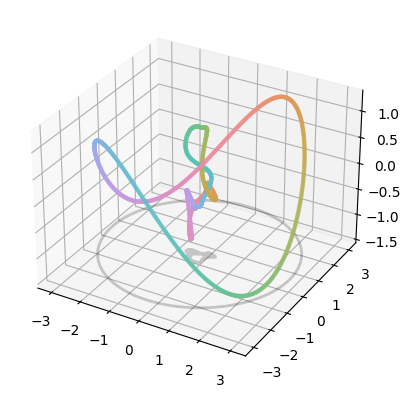

In [ ]:
#@title Plot A Joint PCA Projection of `Xr` and `Yr`.
pca = PCA(3).fit(np.row_stack((Xr, Yr)))
x1, x2, x3 = pca.transform(Xr).T
y1, y2, y3 = pca.transform(Yr).T

fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1, projection='3d')

ax1.scatter(x1, x2, x3, c=thetas, cmap=cyclic_cmap, alpha=.5, lw=0, s=10)
ax1.scatter(y1, y2, y3, c=thetas, cmap=cyclic_cmap, alpha=.5, lw=0, s=10)
ax1.plot(x1, x2, np.full_like(x1, ax1.get_zlim()[0]), '-k', alpha=.2, lw=2)
ax1.plot(y1, y2, np.full_like(y1, ax2.get_zlim()[0]), '-k', alpha=.2, lw=2);

The code above attempts to run a single PCA projection on the randomly rotated neural responses `Xr` and `Yr`. Before, when we ran individual PCA projections on `Xr` and `Yr`, we saw that the two manifolds had similar shapes in the low-dimensional space. Now the two manifolds look quite different from each other.

❗**Notice**❗ *One of the population responses is well-captured by the PCA projection: it appears as a smooth ring manifold.
The other population response is not well captured by the PCA projection: it appears as a smaller, tangled ring manifold near the origin.
Can you explain why this is the case?*

As an answer/hint to the question above, below we do a quick check to show that the PCA does a better job of capturing `Xr`, compared to `Yr`.

In [ ]:
print(
    "Variance explained in X: ", 100 * (1 - np.sum(
        (Xr - pca.inverse_transform(pca.transform(Xr))) ** 2
    ) / np.sum(Xr ** 2))
)
print(
    "Variance explained in Y: ", 100 * (1 - np.sum(
        (Yr - pca.inverse_transform(pca.transform(Yr))) ** 2
    ) / np.sum(Yr ** 2))
)

Variance explained in X:  88.99551632299612
Variance explained in Y:  7.849193898782703


What we saw above is that vertically concatenating $\mathbf{XR}_X$ and $\mathbf{YR}_Y$ into a single matrix and performing PCA mangled the expected geometry.
Now we are going to find the optimal orthogonal matrix $\mathbf{Q}$ so that $\mathbf{XR}_X$ and $\mathbf{YR}_Y\mathbf{Q}$ are geometrically aligned with each other.

The function below computes the optimal $\mathbf{Q}$.

In [ ]:
def optimal_orth_alignment(X, Y):
    """
    Given responses from two neural systems, estimate the optimal
    orthogonal matrix Q that minimizes the sum of squared elements
    of the matrix (X - Y @ Q).

    Parameters
    ----------
    X : ndarray
        Responses from the first network (num_conditions x num_neurons).

    Y  : ndarray
        Responses from the second network (num_conditions x num_neurons)

    Returns
    -------
    Q : ndarray
        Optimal N x N orthogonal matrix that minimizes
        the Frobenius norm of (X - Y @ Q).
    """
    # In this demo notebook we are assuming that X and Y have the same number of
    # neurons, so the shapes of X and Y should match. We will show how to remove
    # this assumption in the next notebook (part 2) of this tutorial.
    assert X.shape == Y.shape
    U, S, Vt = np.linalg.svd(X.T @ Y)
    return Vt.T @ U.T

❗**Wow**❗ The optimal $\mathbf{Q}$ can be computed in two lines of code using very elementary linear algebra! The curious reader with some mathematical background may want to see a proof of this somewhat remarkable fact. Here is a quick sketch of a derivation.



---

The squared Frobenius norm can be expanded and expressed in terms of the [trace operator](https://en.wikipedia.org/wiki/Trace_(linear_algebra)).

\begin{equation}
\Vert \mathbf{X} - \mathbf{YQ}\Vert_F^2 = \text{Tr}[\mathbf{X}^\top \mathbf{X}] + \text{Tr}[\mathbf{Q}^\top \mathbf{Y}^\top \mathbf{YQ}] - 2 \text{Tr}[\mathbf{X}^\top \mathbf{Y} \mathbf{Q}]
\end{equation}

Because $\mathbf{QQ}^\top = \mathbf{I}$ and the [cyclic trace property](https://en.wikipedia.org/wiki/Trace_(linear_algebra)#Cyclic_property),

\begin{equation}
\text{Tr}[\mathbf{Q}^\top \mathbf{Y}^\top \mathbf{YQ}] = \text{Tr}[ \mathbf{Y}^\top \mathbf{YQ Q}^\top] = \text{Tr}[ \mathbf{Y}^\top \mathbf{Y}]
\end{equation}

Thus,

\begin{equation}
\min_{\mathbf{Q} \in O(N)} \Vert \mathbf{X} - \mathbf{YQ}\Vert_F^2 = \text{Tr}[\mathbf{X}^\top \mathbf{X}] + \text{Tr}[\mathbf{Y}^\top \mathbf{Y}] - 2 \max_{\mathbf{Q} \in O(N)}\text{Tr}[\mathbf{X}^\top \mathbf{Y} \mathbf{Q}]
\end{equation}

Let $\mathbf{X}^\top \mathbf{Y} = \mathbf{USV}^\top$ denote a [singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition).
The singular values of $\mathbf{Q}$ are all equal to one, therefore [Von Neumann's trace inequality](https://en.wikipedia.org/wiki/Trace_inequality#Von_Neumann's_trace_inequality_and_related_results) implies that $\text{Tr}[\mathbf{X}^\top \mathbf{Y} \mathbf{Q}] \leq \text{Tr}[\mathbf{S}]$ so if we can find a $\mathbf{Q}$ that saturates this upper bound it must be optimal. Indeed, we find that $\mathbf{Q} = \mathbf{VU}^\top$ is optimal since:

\begin{equation}
\text{Tr}[\mathbf{X}^\top \mathbf{Y} \mathbf{Q}] = \text{Tr}[\mathbf{S} \mathbf{V}^\top \mathbf{Q} \mathbf{U}] = \text{Tr}[\mathbf{S}]
\end{equation}

---

Below we compute the optimal $\mathbf{Q}$ for our simulated data and re-plot the PCA projection of the two neural manifolds after aligning them.

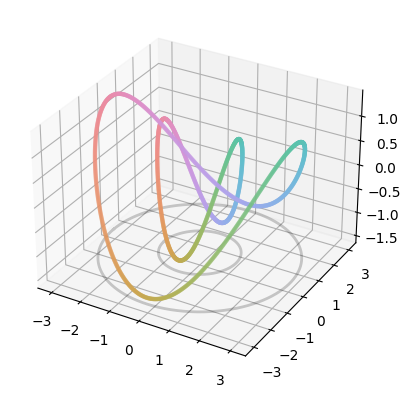

In [ ]:
#@title Visualize PCA after alignment (`Xr` and `Yr @ Q`).
Q = optimal_orth_alignment(Xr, Yr)
pca = PCA(3).fit(np.row_stack((Xr, Yr @ Q)))
x1, x2, x3 = pca.transform(Xr).T
y1, y2, y3 = pca.transform(Yr @ Q).T

fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1, projection='3d')

ax1.scatter(x1, x2, x3, c=thetas, cmap=cyclic_cmap, alpha=.5, lw=0, s=10)
ax1.scatter(y1, y2, y3, c=thetas, cmap=cyclic_cmap, alpha=.5, lw=0, s=10)
ax1.plot(x1, x2, np.full_like(x1, ax1.get_zlim()[0]), '-k', alpha=.2, lw=2)
ax1.plot(y1, y2, np.full_like(y1, ax2.get_zlim()[0]), '-k', alpha=.2, lw=2);

❗**Notice**❗ *In the previous PCA plot the manifold `Yr` appeared mangled and misaligned to `Xr`. Now we have done the same PCA procedure on `Yr @ Q`, and found that the two manifolds indeed have similar shapes. Additionally,*

* *The manifold associated with `Yr` is smaller than `Xr`. Can you come up with an explanation for why `Yr` is smaller, based on the structure of our original tuning curves?*
* *The coloring of the curves, which represents $\theta$, are matched: any two closest points of contact between the two manifolds share the same color.*

As we show below, the PCA projection does a much better job of capturing variance in the aligned responses (`Xr` and `Yr @ Q`) compared to the original responses (`Xr` and `Yr`).

In [ ]:
print(
    "Variance explained in X: ", 100 * (1 - np.sum(
        (Xr - pca.inverse_transform(pca.transform(Xr))) ** 2
    ) / np.sum(Xr ** 2))
)
print(
    "Variance explained in Y: ", 100 * (1 - np.sum(
        (Yr @ Q - pca.inverse_transform(pca.transform(Yr @ Q))) ** 2
    ) / np.sum(Yr ** 2))
)

Variance explained in X:  90.6634043409344
Variance explained in Y:  39.638007468061595


## **Effect of Rescaling Tuning Before Measuring Procrustes Distance**

If you scroll back to the top of this notebook, you'll see that the tuning curves in $\mathbf{X}$ are wider than the tuning curves in $\mathbf{Y}$, while having the same amplitude. Intuitively, the area under the tuning curves in $\mathbf{X}$ is larger, causing the manifold associated with $\mathbf{X}$ to appear "bigger" than the manifold associated with $\mathbf{Y}$ in the PCA plot above. Indeed, the overall variance in $\mathbf{X}$ is higher as we confirm below:

In [ ]:
Xr_variance =  np.sum(Xr * Xr) # Recall that the columns of Xr are already mean-centered
Yr_variance =  np.sum(Yr * Yr) # Recall that the columns of Yr are already mean-centered
print("Variance in X:", Xr_variance)
print("Variance in Y:", Yr_variance)

Variance in X: 11182.442431457064
Variance in Y: 5521.77202553231


Suppose we want to focus on differences in *manifold shape*, instead of manifold *size*. That is, we'd like to ignore differences in overall/average firing rate between the two networks. We can do this very easily by scaling `Xr` and `Yr` so that they have unit variance (i.e. sum of their squared entries equals one).

This gives us a slight variant on the Procrustes distance:

\begin{equation}
d_{\text{proc,scaled}}(\mathbf{X}, \mathbf{Y}) = d_{\text{proc}} \left (\frac{\mathbf{X}}{\Vert \mathbf{CX} \Vert_F}, \frac{\mathbf{Y}}{\Vert \mathbf{CY} \Vert_F} \right ) = \min_{\mathbf{Q} \in O(N)} \left \Vert \frac{\mathbf{CX}}{\Vert \mathbf{CX} \Vert_F} - \frac{\mathbf{CY}}{\Vert \mathbf{CY} \Vert_F} \mathbf{Q} \right \Vert_F
\end{equation}

🤔 **Consider** 🤔 *Is it always a good idea to rescale data this way? Can you give an example when re-scaling like this is necessary to get a good result? Can you give a counterexample where it may be misleading?*

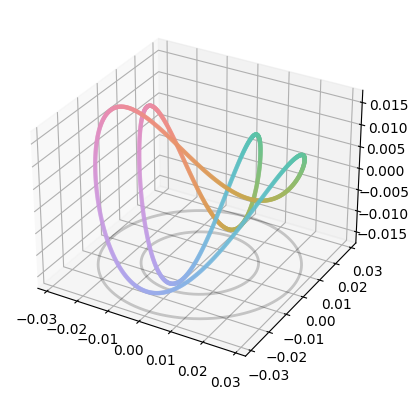

In [ ]:
Xrs = Xr / np.sqrt(Xr_variance)
Yrs = Yr / np.sqrt(Yr_variance)
Q = optimal_orth_alignment(Xrs, Yrs)

pca = PCA(3).fit(np.row_stack((Xrs, Yrs @ Q)))
x1, x2, x3 = pca.transform(Xrs).T
y1, y2, y3 = pca.transform(Yrs @ Q).T

fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1, projection='3d')

ax1.scatter(x1, x2, x3, c=thetas, cmap=cyclic_cmap, alpha=.5, lw=0, s=10)
ax1.scatter(y1, y2, y3, c=thetas, cmap=cyclic_cmap, alpha=.5, lw=0, s=10)
zlim = ax1.get_zlim()
ax1.plot(x1, x2, np.full_like(x1, zlim[0]), '-k', alpha=.2, lw=2)
ax1.plot(y1, y2, np.full_like(y1, zlim[0]), '-k', alpha=.2, lw=2)
ax1.set_zlim(zlim);

After re-scaling the neural manifolds so that their overall size is matched and performing the optimal rotational alignment, we get the PCA projection above.
We see that the two manifolds are still not perfectly aligned: one of them appears slightly smaller and has higher curvature. The reader can confirm that this is the manifold associated with `Yr`, and encouraged to give an interpretation for why `Yr` has larger curvature.

## **Procrustes Alignment vs. Linear Regression**


As a final example, let's consider what happens when we want to fit not only a rotational alignment, but more general linear transformations. How can we adapt the Procrustes distance to this case.
A gut reaction may be to try the following notion of "distance" between $\mathbf{X}$ and $\mathbf{Y}$

\begin{equation}
d_{\text{regression}}(\mathbf{X}, \mathbf{Y}) = \min_{\mathbf{H}} \Vert \mathbf{X} - \mathbf{YH} \Vert_F
\end{equation}

The only difference with the Procrustes distance is that the alignment is parameterized by any linear matrix $\mathbf{H}$, instead of an orthogonal matrix $\mathbf{Q} \in O(N)$.
The resulting quantity is essentially the prediction error of a linear regression model where we predict $\mathbf{X}$ (dependent variable) from $\mathbf{Y}$ (independent variable).

Linear regression is a perfectly fine analysis, but it does not provide an easily interpretable notion "distance" between two neural representations. For one, it is not symmetric:

\begin{equation}
d_{\text{regression}}(\mathbf{X}, \mathbf{Y}) \neq d_{\text{regression}}(\mathbf{Y}, \mathbf{X})
\end{equation}

In other words, the regression "distance" of $\mathbf{X}$ to $\mathbf{Y}$ is not the same as the "distance" from $\mathbf{Y}$ to $\mathbf{X}$. We will return to this concept later in Part 3. The upshot is that *linear predictivity scores and Procrustes shape distance are complementary quantities for studying neural representations&mdash;they measure different things in service of different scientific questions.*

## **Incorporating Linear Invariance to Procrustes Distance**

It turns out that there is a natural way to generalize Procrustes distance from rotational to linear alignments while preserving the nice properties mentioned above (i.e. symmetry and triangle inequality). In particular, we will describe a notion of distance that satisfies:

1. **Distance is zero only when $\mathbf{X}$ and $\mathbf{Y}$ are linearly mappable each other.**
That is, $d(\mathbf{X}, \mathbf{Y}) = 0$ if and only if there exists an invertible $N \times N$ matrix $\mathbf{H}$ such that $\mathbf{X} = \mathbf{YH}$ and $\mathbf{Y} = \mathbf{XH}^{-1}$.

2. **Symmetry.**
$d(\mathbf{X}, \mathbf{Y}) = d(\mathbf{Y}, \mathbf{X})$.

3. **Triangle inequality.** $d(\mathbf{X}, \mathbf{Y}) \leq d(\mathbf{X}, \mathbf{Z}) + d(\mathbf{Z}, \mathbf{Y})$

Condition 2 & 3 are exactly as before, the only difference is our notion of [equivalence](https://en.wikipedia.org/wiki/Equivalence_relation) between two neural responses. Before, we considered $\mathbf{X}$ and $\mathbf{Y}$ to be equivalent if they were equated by an orthogonal alignment matrix $\mathbf{Q}$. Now, we seek a notion of distance that treats $\mathbf{X}$ and $\mathbf{Y}$ as equivalent if they are equated by an invertible matrix.

Recalling a few fundamentals from linear algebra,<sup>1</sup> the relation $\mathbf{X} = \mathbf{YH}$ is equivalent to saying that every column of $\mathbf{X}$ can be formed from a linear combination of the columns in $\mathbf{Y}$.
That is, if there exists an (invertible) matrix $\mathbf{H}$ such that $\mathbf{X} = \mathbf{YH}$, then the [*column space*](https://en.wikipedia.org/wiki/Row_and_column_spaces) of $\mathbf{X}$ must coincide with the column space of $\mathbf{Y}$. This leads to the following trick:

\begin{align}
&\text{let} \quad \mathbf{\tilde{X}}=\mathbf{X(X^\top X)}^{-1/2} \quad \text{and} \quad \mathbf{\tilde{Y}}=\mathbf{Y(Y^\top Y)}^{-1/2}, \\
&\text{then compute} \quad d(\mathbf{X}, \mathbf{Y}) = d_{\text{Proc}}(\mathbf{\tilde{X}}, \mathbf{\tilde{Y}} )
\end{align}

The mapping $\mathbf{X} \mapsto \mathbf{X(X^\top X)}^{-1/2}$ is an example of a [*whitening transformation*](https://en.wikipedia.org/wiki/Whitening_transformation).
It is easy to check that the transformed matrix $\mathbf{\tilde{X}}$ has orthonormal columns, so $\mathbf{\tilde{X}^\top \tilde{X}} = \mathbf{I}$.
The key concept here is that $\mathbf{X}$ and $\mathbf{Y}$ share the same column space, if and only if there exists an orthogonal matrix $\mathbf{Q}$ such that $\mathbf{\tilde{X}} = \mathbf{\tilde{Y}Q}$.
We can find that $\mathbf{Q}$ as described above, and if we wish to recover the linear mapping it is easily done:

\begin{equation}
\mathbf{\tilde{X}} = \mathbf{\tilde{Y}Q} ~~\Rightarrow~~ \mathbf{X} = \mathbf{Y}(\mathbf{Y^\top Y})^{-1/2} \mathbf{Q} (\mathbf{X^\top X})^{1/2} = \mathbf{YH}
\end{equation}

In the last equality we have set the optimal linear mapping to be:

\begin{equation}
\mathbf{H} = (\mathbf{Y^\top Y})^{-1/2} \mathbf{Q} (\mathbf{X^\top X})^{1/2}
\end{equation}

We explore an implementation of this idea in the code below.

---
<sup>1</sup> *Chapter 3 of Gilbert Strang's [Introduction to Linear Algebra](https://math.mit.edu/~gs/linearalgebra/ila6/indexila6.html) covers the necessary background for this portion of the tutorial.*

In [ ]:
#@title Implement function for whitening transformation

def partial_whitening(A, alpha):
    """
    Compute a partial whitening transformation.

    Parameters
    ----------
    A : ndarray
        A positive semidefinite matrix.

    alpha : float
        Regularization parameter.

    Returns
    -------
    W : ndarray
        A partial whitening matrix. When alpha = 0, the covariance of A @ W
        is the identity matrix. When alpha = 1, we get A @ W = A and W is the
        identity matrix.
    """
    # Compute inverse square root of eigenvalues of `A`.
    eigvals, U = np.linalg.eigh(A)
    invsqrt = 1 / np.sqrt(np.maximum(eigvals, 1e-6))

    # Regularize inverse by parameter 0 <= alpha <= 1.
    d = alpha + (1 - alpha) * invsqrt

    # Return regularized whitening matrix.
    return (U * d[None, :]) @ U.T

The function above computes a *regularized* whitening transformation, which is tuned by a parameter $0 \leq \alpha \leq 1$. Formally, let $\mathbf{U} \boldsymbol{\Lambda} \mathbf{U}^\top$ be the eigendecomposition of the symmetric, positive definite matrix $\mathbf{X}^\top \mathbf{X}$.
Then, assuming all eigenvalues are strictly positive, $(\mathbf{X^\top X})^{-1/2} = \mathbf{U}\boldsymbol{\Lambda}^{-1/2}\mathbf{U}^\top$. If some of the eigenvalues are nearly zero, the elements of $\boldsymbol{\Lambda}^{-1/2}$ blow up to infinity. Thus, we consider the regularized whitening transformation.

\begin{equation}
\mathbf{X} \mapsto \mathbf{X} \mathbf{U}(\alpha \mathbf{I} + (1-\alpha)\boldsymbol{\Lambda}^{-1/2})\mathbf{U}^\top
\end{equation}

This has two benefits. First, we don't need to worry about the case where the matrix $(\mathbf{X^\top X})^{-1/2}$ is singular (not invertible). Secondly, it allows us to smoothly interpolate between a purely rotational alignment ($\alpha = 1$) and a linear alignment ($\alpha = 0$). When $\alpha=1$ we recover the Procrustes distance. When $\alpha=0$, it turns out that we get a notion of distance that is closely related to [canonical correlations analysis (CCA)](https://en.wikipedia.org/wiki/Canonical_correlation). For details, see [Williams et al. (2021)](https://proceedings.neurips.cc/paper/2021/hash/252a3dbaeb32e7690242ad3b556e626b-Abstract.html).

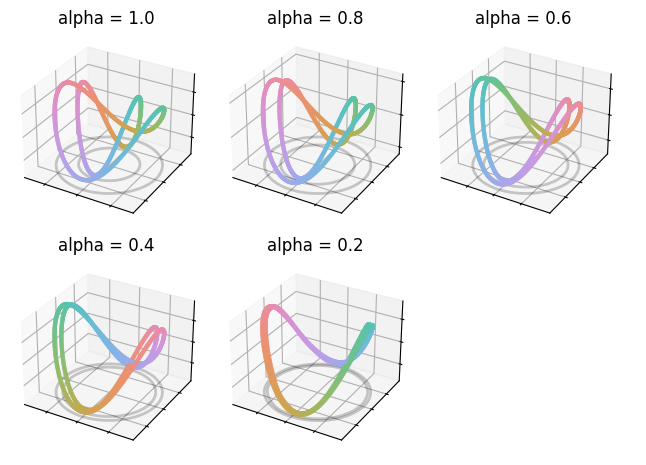

In [ ]:
fig = plt.figure()

for i, alpha in enumerate([1.0, 0.8, 0.6, 0.4, 0.2]):

    ax = fig.add_subplot(2, 3, i + 1, projection='3d')

    Xrsw = Xrs @ partial_whitening(Xrs.T @ Xrs, alpha)
    Yrsw = Yrs @ partial_whitening(Yrs.T @ Yrs, alpha)
    Q = optimal_orth_alignment(Xrsw, Yrsw)

    pca = PCA(3).fit(np.row_stack((Xrsw, Yrsw @ Q)))
    x1, x2, x3 = pca.transform(Xrsw).T
    y1, y2, y3 = pca.transform(Yrsw @ Q).T

    ax.scatter(x1, x2, x3, c=thetas, cmap=cyclic_cmap, alpha=.5, lw=0, s=10)
    ax.scatter(y1, y2, y3, c=thetas, cmap=cyclic_cmap, alpha=.5, lw=0, s=10)
    zlim = ax.get_zlim()
    ax.plot(x1, x2, np.full_like(x1, zlim[0]), '-k', alpha=.2, lw=2)
    ax.plot(y1, y2, np.full_like(y1, zlim[0]), '-k', alpha=.2, lw=2)
    ax.set_zlim(zlim);
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_title(f"alpha = {alpha}")

fig.tight_layout()

Try going back to the cell where we defined our neural representation matrices X and Y, and changing the tuning width and amplitude parameters.  How does this change our results?  